In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
    compress_repeated_epochs
)
from ripple_heterogeneity.assembly import assembly_reactivation,find_sig_assembly
from ripple_heterogeneity.readout import assembly_multi_region
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import os
import nelpy as nel
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator
from neo.rawio import neuroscoperawio
import nelpy.plotting as npl
from ripple_heterogeneity.utils import scalebars
import pickle
import glob

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [59]:
prop_df_, assembly_df_, keep_assembly_ = assembly_multi_region.compile_results_df(results)
prop_df_

,prop_cross_region,n_cross_region,labels,n_deep,n_sup,n_mec,n_pfc,n_assemblies,basepath
0,0.000,0,Superficial PFC,8,5,19,0,8,Z:\Data\AYAold\AYA7\day27
1,0.125,1,Superficial MEC,8,5,19,0,8,Z:\Data\AYAold\AYA7\day27
2,0.000,0,Deep PFC,8,5,19,0,8,Z:\Data\AYAold\AYA7\day27
3,0.125,1,Deep MEC,8,5,19,0,8,Z:\Data\AYAold\AYA7\day27


In [ ]:
import warnings
warnings.filterwarnings("ignore")

save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt"

sessions = glob.glob(save_path + os.sep + "*.pkl")
for session in sessions:
    with open(session, "rb") as f:
        results = pickle.load(f)
    
    df_strength = assembly_multi_region.load_reactivation(results)
    labels = ["deep_mec", "deep_pfc", "superficial_mec", "superficial_pfc"]

    df_strength["single_cross_region"] = df_strength[labels].sum(axis=1) == 1

    out = [labels[val] for val in np.argmax(df_strength[labels].values, axis=1)]
    df_strength["single_cross_region_label"] = out
    df_strength.loc[
        df_strength.single_cross_region == False, "single_cross_region_label"
    ] = "unknown"

    deep_mec_assem_n = df_strength[
        df_strength.single_cross_region_label == "deep_mec"
    ].assembly_n.unique()
    deep_pfc_assem_n = df_strength[
        df_strength.single_cross_region_label == "deep_pfc"
    ].assembly_n.unique()
    superficial_mec_assem_n = df_strength[
        df_strength.single_cross_region_label == "superficial_mec"
    ].assembly_n.unique()
    superficial_pfc_assem_n = df_strength[
        df_strength.single_cross_region_label == "superficial_pfc"
    ].assembly_n.unique()
    other_assemblies = df_strength[
        df_strength.single_cross_region == False
    ].assembly_n.unique()

    print(
        f"{session}: n_deep_mec = {len(deep_mec_assem_n)} n_deep_pfc = {len(deep_pfc_assem_n)} n_sup_mec = {len(superficial_mec_assem_n)} n_sup_pfc = {len(superficial_pfc_assem_n)}"
    )


In [46]:
deep_mec_assem_n

array([23.])

In [48]:
assembly_label_df = pd.DataFrame()
assembly_label_df["label"] = ["unknown"] * len(df_strength.assembly_n.unique())
assembly_label_df.iloc[int(deep_mec_assem_n)] = "deep_mec"
assembly_label_df.iloc[int(deep_pfc_assem_n)] = "deep_pfc"
assembly_label_df.iloc[int(superficial_mec_assem_n)] = "superficial_mec"
assembly_label_df.iloc[int(superficial_pfc_assem_n)] = "superficial_pfc"

assembly_label_df

TypeError: only size-1 arrays can be converted to Python scalars

In [37]:
deep_mec_assem_n, deep_pfc_assem_n, superficial_mec_assem_n, superficial_pfc_assem_n


(array([23.]),
 array([ 0., 12., 13., 17.]),
 array([], dtype=float64),
 array([25.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 14., 15.,
        16., 18., 19., 20., 21., 22., 24., 26., 27., 28., 29., 30., 31.,
        32., 33., 34., 35., 36., 37., 38., 39., 40.]))

In [3]:
session = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_50ms_dt_10ms_z_dt\Z__Data_HMC1_day8.pkl"
# session = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_v1\Z__Data_AYAold_AYA9_day15.pkl"

# Z:\Data\AYAold\AYA9\day15
with open(session, "rb") as f:
    results = pickle.load(f)


In [4]:
from xml.etree import ElementTree


def parse_xml_channel_groups(filename):
    filename = filename.replace(".xml", "").replace(".dat", "")

    tree = ElementTree.parse(filename + ".xml")
    root = tree.getroot()

    # find channels
    channel_group = []
    for grp_index, xml_chx in enumerate(
        root.find("anatomicalDescription").find("channelGroups").findall("group")
    ):
        for xml_rc in xml_chx:
            channel_group.append([int(xml_rc.text), grp_index])
    return np.array(channel_group)


reader = neuroscoperawio.NeuroScopeRawIO("Z:/Data/HMC1/day8/day8")
reader.parse_header()
channel_group = parse_xml_channel_groups(reader.filename)
shank = 9
channel_indexes = channel_group[channel_group[:, 1] == shank, 0]


In [72]:
channel_indexes


array([288, 301, 306, 319, 302, 305, 289, 303, 304, 290, 300, 307, 291,
       299, 308, 292, 298, 309, 293, 297, 310, 318, 296, 311, 317, 295,
       312, 316, 294, 313, 315, 314])

In [5]:
channel_indexes = [293, 314]
rip = 1
seconds_idx = np.array(
    [results["react"].ripples[rip].start, results["react"].ripples[rip].stop]
)

# convert to index
to_idx = (seconds_idx * reader.get_signal_sampling_rate()).astype(int)
# get chunk of data
raw_sigs = reader.get_analogsignal_chunk(
    i_start=to_idx[0], i_stop=to_idx[1], channel_indexes=channel_indexes
)


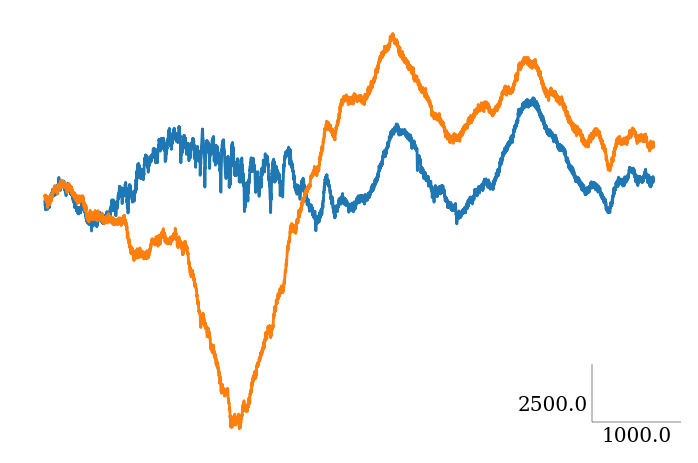

In [6]:
plt.plot(raw_sigs)
sb = scalebars.add_scalebar(plt.gca())


In [12]:
results


{'assembly_act_pre': <AnalogSignalArray at 0x1f265093490: 45 signals (4,052 segments)> for a total of 12:33:524 minutes,
 'assembly_act_task': <AnalogSignalArray at 0x1f26509d8e0: 45 signals (776 segments)> for a total of 2:11:762 minutes,
 'assembly_act_post': <AnalogSignalArray at 0x1f26509dbe0: 45 signals (5,227 segments)> for a total of 16:20:389 minutes,
 'react': <ripple_heterogeneity.assembly.assembly_reactivation.AssemblyReact at 0x1f26509de20>}

In [7]:
patterns, is_member_sig, keep_assembly, is_member = find_sig_assembly.main(
    results.get("react").patterns
)


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


In [8]:
df_strength = assembly_multi_region.load_reactivation(results)
df_strength

,strength,assembly_n,ripple_n,sig,epoch,deep_mec,deep_pfc,superficial_mec,superficial_pfc,basepath
0,2.226665,0.0,0.0,1.0,pre,0.0,0.0,0.0,0.0,Z:\Data\HMC1\day8
1,1.194391,0.0,1.0,1.0,pre,0.0,0.0,0.0,0.0,Z:\Data\HMC1\day8
2,1.892833,0.0,2.0,1.0,pre,0.0,0.0,0.0,0.0,Z:\Data\HMC1\day8
3,1.868581,0.0,3.0,1.0,pre,0.0,0.0,0.0,0.0,Z:\Data\HMC1\day8
4,1.576082,0.0,4.0,1.0,pre,0.0,0.0,0.0,0.0,Z:\Data\HMC1\day8
...,...,...,...,...,...,...,...,...,...,...
226835,2.285503,39.0,3512.0,0.0,post,1.0,1.0,1.0,1.0,Z:\Data\HMC1\day8
226836,1.030763,39.0,3513.0,0.0,post,1.0,1.0,1.0,1.0,Z:\Data\HMC1\day8
226837,2.257136,39.0,3514.0,0.0,post,1.0,1.0,1.0,1.0,Z:\Data\HMC1\day8
226838,0.504168,39.0,3515.0,0.0,post,1.0,1.0,1.0,1.0,Z:\Data\HMC1\day8


In [9]:
df_strength = assembly_multi_region.load_reactivation(results)

labels = ["deep_mec", "deep_pfc", "superficial_mec", "superficial_pfc"]

df_strength["single_cross_region"] = df_strength[labels].sum(axis=1) == 1

out = [labels[val] for val in np.argmax(df_strength[labels].values, axis=1)]
df_strength["single_cross_region_label"] = out
df_strength.loc[df_strength.single_cross_region == False, "single_cross_region_label"] = "unknown"

deep_mec_assem_n = df_strength[
    df_strength.single_cross_region_label == "deep_mec"
].assembly_n.unique()
deep_pfc_assem_n = df_strength[
    df_strength.single_cross_region_label == "deep_pfc"
].assembly_n.unique()
superficial_mec_assem_n = df_strength[
    df_strength.single_cross_region_label == "superficial_mec"
].assembly_n.unique()
superficial_pfc_assem_n = df_strength[
    df_strength.single_cross_region_label == "superficial_pfc"
].assembly_n.unique()
other_assemblies = df_strength[
    df_strength.single_cross_region == False
].assembly_n.unique()


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


In [10]:
deep_mec_assem_n, deep_pfc_assem_n, superficial_mec_assem_n, superficial_pfc_assem_n, other_assemblies


(array([], dtype=float64),
 array([11.]),
 array([15.]),
 array([], dtype=float64),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 12., 13.,
        14., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.]))

In [283]:
# df_strength[df_strength.single_cross_region_label == "deep_pfc"].iloc[np.argsort(-df_strength[df_strength.single_cross_region_label == "deep_pfc"].strength)]


In [282]:
# temp_df = df_strength.copy()
# offset = 0
# for epoch in temp_df.epoch.unique():
#     temp_df.loc[temp_df.epoch == epoch, "ripple_n"] = (
#         temp_df[temp_df.epoch == epoch].ripple_n.values + offset
#     )
#     # update offset
#     offset = temp_df[temp_df.epoch == epoch].ripple_n.max() + 1

# # temp_df[temp_df.single_cross_region_label == "deep_pfc"].iloc[np.argsort(-temp_df[temp_df.single_cross_region_label == "deep_pfc"].strength)]

# temp_df[
#     (temp_df.single_cross_region_label == "deep_pfc") & (temp_df.epoch == "post")
# ].iloc[
#     np.argsort(
#         -temp_df[
#             (temp_df.single_cross_region_label == "deep_pfc")
#             & (temp_df.epoch == "post")
#         ].strength
#     )
# ]


In [11]:
def plot_deep_sup_assembly_example(m1, reader, assembly_act, colors, start, stop):
    fig, axs = plt.subplots(
        3,
        1,
        figsize=functions.set_size("thesis", fraction=0.5, subplots=(2, 1)),
        edgecolor=None,
    )
    fig.subplots_adjust(hspace=0, wspace=0.2)
    axs = axs.ravel()

    group_colors = {
        "MEC": "#de2020",
        "PFC": "#116f70",
        "Deep": "#7b3294",
        "Superficial": "#008837",
    }
    group_colors_assemblies = {
        "deep_mec": "#de2020",
        "superficial_mec": "#eb8383",
        "deep_pfc": "#0a4242",  #  "#116f70"
        "superficial_pfc": "#6eb5b5",  # "#568c8c"
    }
    # rip = 9
    # rip = 1358
    # rip = 5325
    # rip = 88

    window = 0.5
    # plotting_epoch = nel.EpochArray([np.array([m1.ripples[rip].start - window / 2, m1.ripples[rip].stop + window / 2]).T])
    # middle = np.median([m1.ripples[rip].start, m1.ripples[rip].stop])
    # plotting_epoch = nel.EpochArray(
    #     [np.array([middle - window / 2, middle + window / 2]).T]
    # )
    plotting_epoch = nel.EpochArray([np.array([start, stop]).T])

    seconds_idx = np.array([plotting_epoch.start, plotting_epoch.stop])
    # convert to index
    to_idx = (seconds_idx * reader.get_signal_sampling_rate()).astype(int)
    # get chunk of data
    raw_sigs = reader.get_analogsignal_chunk(
        i_start=to_idx[0], i_stop=to_idx[1], channel_indexes=channel_indexes
    )

    ts = np.linspace(plotting_epoch.start, plotting_epoch.stop, raw_sigs.shape[0])
    axs[0].plot(ts, raw_sigs[:, 0], color="k", linewidth=0.25)

    ca1_deep_idx = (m1.cell_metrics.brainRegion.str.contains("CA1") & m1.cell_metrics.deepSuperficial.str.contains("Deep")).values
    ca1_sup_idx = (m1.cell_metrics.brainRegion.str.contains("CA1") & m1.cell_metrics.deepSuperficial.str.contains("Superficial")).values
    pfc_idx = m1.cell_metrics.brainRegion.str.contains("PFC").values
    mec_idx = m1.cell_metrics.brainRegion.str.contains("MEC").values

    peak_order = m1.st[plotting_epoch].iloc[:, ca1_sup_idx].get_event_firing_order()
    npl.rasterplot(
        m1.st[plotting_epoch].iloc[:, ca1_sup_idx],
        lw=1,
        lh=7,
        ax=axs[1],
        color=group_colors["Superficial"],
        vertstack=True,
    )
    peak_order = m1.st[plotting_epoch].iloc[:, ca1_deep_idx].get_event_firing_order()
    npl.rasterplot(
        m1.st[plotting_epoch].iloc[:, ca1_deep_idx],
        lw=1,
        lh=7,
        ax=axs[1],
        color=group_colors["Deep"],
        vertstack=True,
    )

    peak_order = m1.st[plotting_epoch].iloc[:, pfc_idx].get_event_firing_order()
    npl.rasterplot(
        m1.st[plotting_epoch].iloc[:, pfc_idx],
        lw=1,
        lh=7,
        ax=axs[1],
        color=group_colors["PFC"],
        vertstack=True,
    )

    peak_order = m1.st[plotting_epoch].iloc[:, mec_idx].get_event_firing_order()
    npl.rasterplot(
        m1.st[plotting_epoch].iloc[:, mec_idx],
        lw=1,
        lh=7,
        ax=axs[1],
        color=group_colors["MEC"],
        vertstack=True,
    )

    m1.z_mat_dt = 0.002
    assembly_act = m1.get_assembly_act(epoch=plotting_epoch)

    for i, color in enumerate(colors):
        axs[2].plot(
            assembly_act[plotting_epoch].abscissa_vals,
            assembly_act[plotting_epoch].data[i],
            color=color,
        )

    # axs[1].set_ylim(-2,m1.cell_metrics.UID.unique().shape[0])
    # axs[1].set_ylim(-2,m1.cell_metrics.UID.unique().shape[0])
    # axs[1].set_yticks(np.linspace(0,m1.cell_metrics.UID.unique().shape[0],2))
    # axs[1].set_xticklabels(np.linspace(0,m1.cell_metrics.UID.unique().shape[0],2))
    axs[1].set_ylabel("Unit ID")

    axs[2].set_ylabel("Assembly \n strength")
    axs[2].set_xlabel("time (sec)")

    for i in range(3):
        axs[i].spines["top"].set_visible(False)
        axs[i].spines["right"].set_visible(False)
        axs[i].xaxis.set_minor_locator(AutoMinorLocator())
        axs[i].set_xlim(plotting_epoch.start, plotting_epoch.stop)

    # x = np.linspace(plotting_epoch.start, plotting_epoch.stop, 4)
    # axs[2].set_xticks(x)
    # axs[2].set_xticklabels(np.round(x - plotting_epoch.start, 2))

    axs[0].axes.xaxis.set_visible(False)
    axs[0].axes.yaxis.set_visible(False)
    axs[0].spines["top"].set_visible(False)
    axs[0].spines["bottom"].set_visible(False)
    axs[0].spines["right"].set_visible(False)
    axs[0].spines["left"].set_visible(False)

    axs[1].spines["bottom"].set_visible(False)
    axs[1].axes.xaxis.set_visible(False)
    # axs[1].spines["left"].set_visible(False)
    axs[1].axes.yaxis.set_visible(False)
    
    # axs[1].yaxis.set_minor_locator(AutoMinorLocator())
    axs[2].yaxis.set_minor_locator(AutoMinorLocator())
    axs[2].xaxis.set_minor_locator(AutoMinorLocator())
    
    return axs


In [12]:
results["react"].z_mat_dt = 0.03
assembly_act = results["react"].get_assembly_act()

In [ ]:
assembly_label_df = pd.DataFrame()
assembly_label_df["label"] = ["unknown"] * len(df_strength.assembly_n.unique())
# assembly_label_df.iloc[int(deep_mec_assem_n)] = "deep_mec"
assembly_label_df.iloc[int(deep_pfc_assem_n)] = "deep_pfc"
assembly_label_df.iloc[int(superficial_mec_assem_n)] = "superficial_mec"
# assembly_label_df.iloc[int(superficial_pfc_assem_n)] = "superficial_pfc"

assembly_label_df

In [14]:
group_colors_assemblies = {
    "deep_mec": "#de2020",
    "superficial_mec": "#eb8383",
    "deep_pfc": "#0a4242",  #  "#116f70"
    "superficial_pfc": "#6eb5b5",  # "#568c8c"
}
colors = ["#808080"] * (len(assembly_label_df))
colors = np.array(colors)
colors[assembly_label_df.label == "deep_pfc"] = [group_colors_assemblies["deep_pfc"]]
colors[assembly_label_df.label == "superficial_mec"] = [group_colors_assemblies["superficial_mec"]]

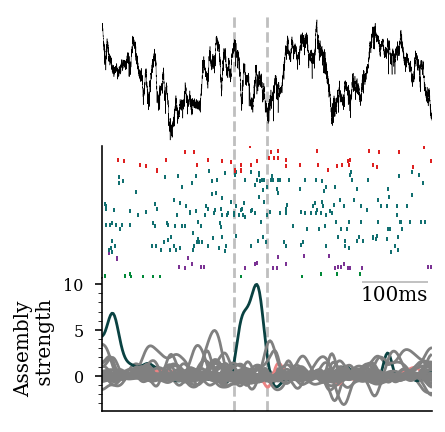

In [15]:
from ripple_heterogeneity.utils import scalebars
time = 9714.7111
window = 0.25
axs = plot_deep_sup_assembly_example(results["react"],reader,results["assembly_act_pre"],colors,time-window,time+window)
for i in range(3):
    axs[i].axvline(time-.05,color="grey",linestyle="--",alpha=.5,zorder=-1000)
    axs[i].axvline(time,color="grey",linestyle="--",alpha=.5,zorder=-1000)

scalebars.add_scalebar(axs[2], sizex=.1, labelx="100ms", labely="None",matchx=False, matchy=False, hidex=True, hidey=False,loc=1)

# axs[1].axvline(time-.05,color="grey",linestyle="--",zorder=-1000)
# axs[2].axvline(time-.05,color="grey",linestyle="--",zorder=-1000)

plt.savefig(
    os.path.join(fig_save_path, "cross_region_raster_assembly_activity_example_deep_pfc.svg"),
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

In [181]:
results["react"].st

<SpikeTrainArray at 0x17da05ba5e0: 258 units> at 20000 Hz

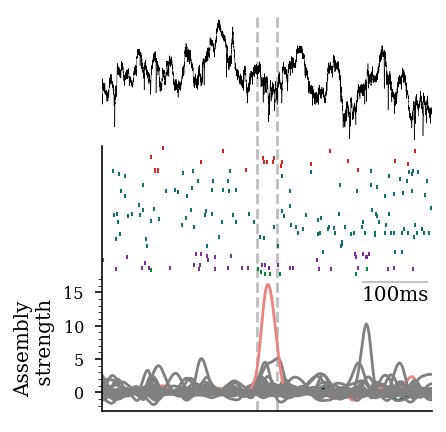

In [223]:
time = 9633.8311
window = 0.25
axs = plot_deep_sup_assembly_example(results["react"],reader,results["assembly_act_pre"],colors,time-window,time+window)
for i in range(3):
    axs[i].axvline(time-.015,color="grey",linestyle="--",alpha=.5,zorder=-1000)
    axs[i].axvline(time+.015,color="grey",linestyle="--",alpha=.5,zorder=-1000)

scalebars.add_scalebar(axs[2], sizex=.1, labelx="100ms", labely="None",matchx=False, matchy=False, hidex=True, hidey=False,loc=1)

plt.savefig(
    os.path.join(fig_save_path, "cross_region_raster_assembly_activity_example_sup_mec.svg"),
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)


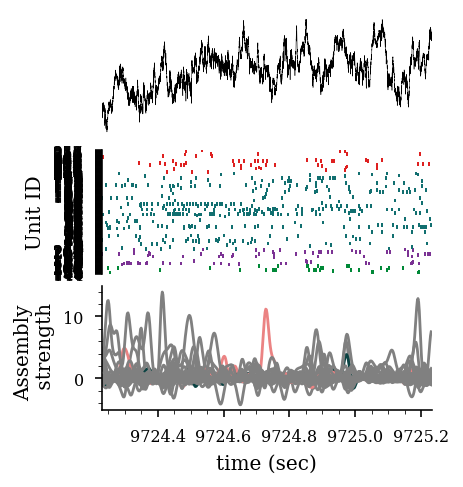

In [179]:
plot_deep_sup_assembly_example(results["react"],reader,results["assembly_act_pre"],colors,9724.7311-.5,9724.7311+.5)


In [157]:
assembly_act[plotting_epoch].abscissa_vals

array([9605.81, 9605.84, 9605.87, 9605.9 , 9605.93, 9605.96, 9605.99,
       9606.02, 9606.05, 9606.08, 9606.11, 9606.14, 9606.17, 9606.2 ,
       9606.23, 9606.26, 9606.29, 9606.32, 9606.35, 9606.38, 9606.41,
       9606.44, 9606.47, 9606.5 , 9606.53, 9606.56, 9606.59, 9606.62,
       9606.65, 9606.68, 9606.71, 9606.74, 9606.77])

In [16]:
np.where(assembly_label_df.label == "deep_pfc")

(array([11], dtype=int64),)

In [17]:
from scipy.signal import find_peaks

x = assembly_act.data[11]
peaks, _ = find_peaks(x,height=60)

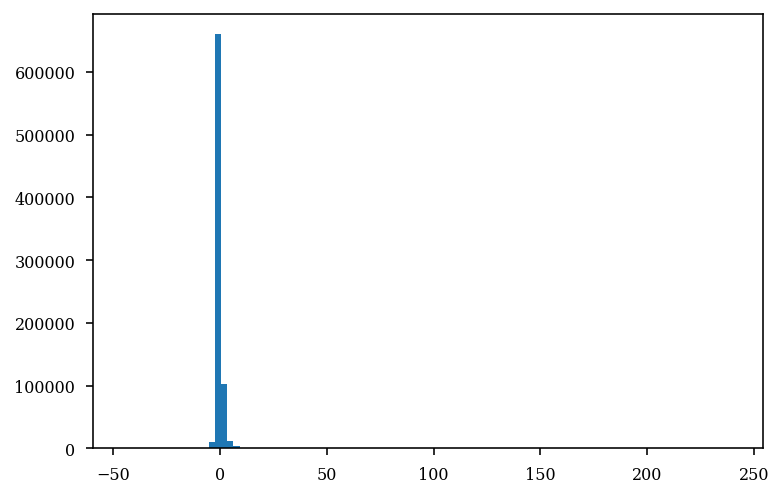

In [18]:
plt.hist(assembly_act.data[11],100)
plt.show()

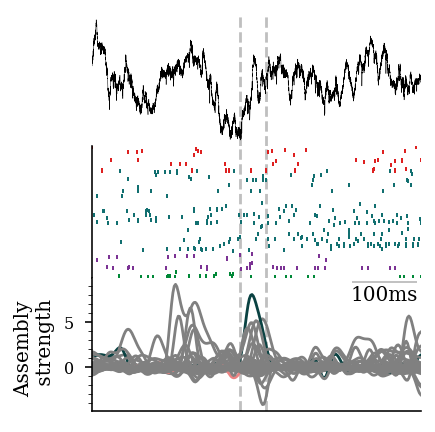

In [34]:
time = 9886.1611
window = 0.25
axs = plot_deep_sup_assembly_example(results["react"],reader,results["assembly_act_pre"],colors,time-window,time+window)
for i in range(3):
    axs[i].axvline(time-.025,color="grey",linestyle="--",alpha=.5,zorder=-1000)
    axs[i].axvline(time+.015,color="grey",linestyle="--",alpha=.5,zorder=-1000)
scalebars.add_scalebar(axs[2], sizex=.1, labelx="100ms", labely="None",matchx=False, matchy=False, hidex=True, hidey=False,loc=1)

plt.savefig(
    os.path.join(fig_save_path, "cross_region_raster_assembly_activity_example_deep_pfc_v2.svg"),
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

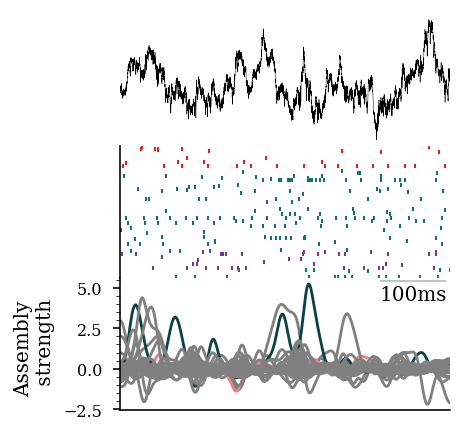

In [28]:
time = 9899.0311
window = 0.25
axs = plot_deep_sup_assembly_example(results["react"],reader,results["assembly_act_pre"],colors,time-window,time+window)
# for i in range(3):
#     axs[i].axvline(time-.05,color="grey",linestyle="--",alpha=.5,zorder=-1000)
#     axs[i].axvline(time,color="grey",linestyle="--",alpha=.5,zorder=-1000)
scalebars.add_scalebar(axs[2], sizex=.1, labelx="100ms", labely="None",matchx=False, matchy=False, hidex=True, hidey=False,loc=1)


In [19]:
assembly_act.abscissa_vals[peaks]

array([  346.5211,   431.6011,  3234.3211,  5762.6611,  5904.1411,
        9139.0411,  9210.3211,  9603.6811,  9640.5211,  9644.0311,
        9654.1111,  9677.5711,  9714.7111,  9736.0411,  9750.5611,
        9778.3711,  9823.7311,  9832.0111,  9837.9211,  9886.1611,
        9889.1011,  9890.6911,  9899.0311,  9902.6911,  9907.7611,
        9929.6311,  9929.7211,  9934.5211,  9960.9511,  9966.2611,
        9984.8911, 10010.9011, 10026.0211, 10029.1711, 10044.9511,
       10045.0111, 10106.2411, 10108.9111, 10115.3911, 10143.0511,
       10143.7411, 10143.8011, 10152.0211, 10152.0811, 10187.7511,
       10189.3111, 10221.3511, 10221.4411, 10223.1511, 10290.1711,
       10290.9511, 10353.7111, 10361.7811, 10424.3311, 10449.7111,
       10454.8711, 10481.8711, 10518.4711, 10518.5611, 10545.8911,
       10656.5311, 10773.5311, 10820.7211, 10938.6811, 11111.3011,
       11183.9611, 11184.0511, 11184.8011, 11189.0011, 11201.6611,
       11279.6311, 11441.1211, 11441.1811, 11441.2711, 11978.5

In [ ]:
rip = 9930

fig, axs = plt.subplots(
    3,
    1,
    figsize=functions.set_size("thesis", fraction=0.7, subplots=(3, 1)),
    edgecolor=None,
)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
axs = axs.ravel()

results["react"].ripples[rip].start, results["react"].ripples[rip].stop
plotting_epoch = nel.EpochArray([np.array([middle - window / 2, middle + window / 2]).T])

# plot raw signal
channel_indexes = [293, 314]

    seconds_idx = np.array([plotting_epoch.start,plotting_epoch.stop])

seconds_idx = np.array(
    [results["react"].ripples[rip].start, results["react"].ripples[rip].stop]
)
# convert to index
to_idx = (seconds_idx * reader.get_signal_sampling_rate()).astype(int)
# get chunk of data
raw_sigs = reader.get_analogsignal_chunk(
    i_start=to_idx[0], i_stop=to_idx[1], channel_indexes=channel_indexes
)
ts = np.linspace(
    results["react"].ripples[rip].start,
    results["react"].ripples[rip].stop,
    raw_sigs.shape[0],
)

axs[0].plot(ts, raw_sigs, color="k", linewidth=0.5)
# scalebars.add_scalebar(axs[0])

# plot raster
group_colors = {
    "MEC": "#de2020",
    "PFC": "#116f70",
    "Deep": "#7b3294",
    "Superficial": "#008837",
}
group_colors_assemblies = {
    "deep_mec": "#de2020",
    "superficial_mec": "#eb8383",
    "deep_pfc": "#0a4242",  #  "#116f70"
    "superficial_pfc": "#6eb5b5",  # "#568c8c"
}
ca1_deep_idx = (results["react"].cell_metrics.brainRegion.str.contains("CA1") & results["react"].cell_metrics.deepSuperficial.str.contains("Deep")).values
ca1_sup_idx = (results["react"].cell_metrics.brainRegion.str.contains("CA1") & results["react"].cell_metrics.deepSuperficial.str.contains("Superficial")).values
pfc_idx = results["react"].cell_metrics.brainRegion.str.contains("PFC").values
mec_idx = results["react"].cell_metrics.brainRegion.str.contains("MEC").values

npl.rasterplot(
    results["react"].st[results["react"].ripples[rip]].iloc[:, ca1_sup_idx],
    lw=2,
    lh=6,
    ax=axs[1],
    color=group_colors["Superficial"],
    vertstack=True,
)

# ymin, ymax = axs[1].get_ylim()
# axs[1].axhline(ymax, color="k", linewidth=1)

npl.rasterplot(
    results["react"].st[results["react"].ripples[rip]].iloc[:, ca1_deep_idx],
    lw=2,
    lh=6,
    ax=axs[1],
    color=group_colors["Deep"],
    vertstack=True,
)
# ymin, ymax = axs[1].get_ylim()
# axs[1].axhline(ymax, color="k", linewidth=1)

npl.rasterplot(
    results["react"].st[results["react"].ripples[rip]].iloc[:, pfc_idx],
    lw=2,
    lh=6,
    ax=axs[1],
    color=group_colors["PFC"],
    vertstack=True,
)
# ymin, ymax = axs[1].get_ylim()
# axs[1].axhline(ymax, color="k", linewidth=1)
npl.rasterplot(
    results["react"].st[results["react"].ripples[rip]].iloc[:, mec_idx],
    lw=2,
    lh=6,
    ax=axs[1],
    color=group_colors["MEC"],
    vertstack=True,
)
# ymin, ymax = axs[1].get_ylim()
# axs[1].axhline(ymax, color="k", linewidth=1)

# plot assembly strength
axs[2].plot(
    results["assembly_act_post"][results["react"].ripples[rip]].abscissa_vals,
    results["assembly_act_post"][results["react"].ripples[rip]]
    .data[other_assemblies.astype(int), :]
    .T,
    color="grey",
)
axs[2].plot(
    results["assembly_act_post"][results["react"].ripples[rip]].abscissa_vals,
    results["assembly_act_post"][results["react"].ripples[rip]]
    .data[deep_pfc_assem_n.astype(int), :]
    .T,
    color=group_colors_assemblies["deep_pfc"],
)
axs[2].plot(
    results["assembly_act_post"][results["react"].ripples[rip]].abscissa_vals,
    results["assembly_act_post"][results["react"].ripples[rip]]
    .data[superficial_pfc_assem_n.astype(int), :]
    .T,
    color=group_colors_assemblies["superficial_pfc"],
)
sns.despine()
axs[2].set_xlabel("Time (s)")

for ax in axs:
    ax.set_xlim(results["react"].ripples[rip].start, results["react"].ripples[rip].stop)

axs[1].axes.get_yaxis().set_visible(False)

x = np.linspace(plotting_epoch.start,plotting_epoch.stop,4)
axs[2].set_xticks(x)
axs[2].set_xticklabels(np.round(x-plotting_epoch.start,2))


## plot assembly strength examples

### plot pfc assembly strength plots

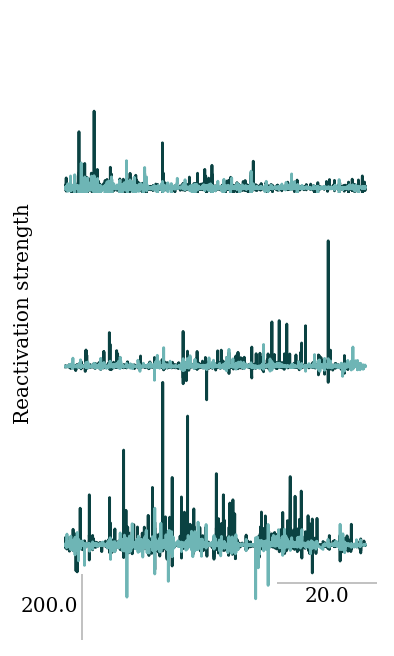

In [257]:
fig, axs = plt.subplots(
    3,
    1,
    figsize=functions.set_size("thesis", fraction=0.5, subplots=(3, 1)),
    edgecolor=None,
    sharey=True,
)
fig.subplots_adjust(hspace=-0.25, wspace=0.1)
axs = axs.ravel()
fig.patch.set_alpha(0)

epoch = nel.EpochArray(
    [
        results["assembly_act_pre"].abscissa_vals.min(),
        results["assembly_act_pre"].abscissa_vals.min() + 60 * 60,
    ]
)

axs[0].plot(
    results["assembly_act_pre"][epoch].abscissa_vals / 60,
    results["assembly_act_pre"][epoch].data[deep_pfc_assem_n.astype(int), :].T,
    color=group_colors_assemblies["deep_pfc"],
)
axs[0].plot(
    results["assembly_act_pre"][epoch].abscissa_vals / 60,
    results["assembly_act_pre"][epoch].data[superficial_pfc_assem_n.astype(int), :].T,
    color=group_colors_assemblies["superficial_pfc"],
)

epoch = nel.EpochArray(
    [
        results["assembly_act_task"].abscissa_vals.min(),
        results["assembly_act_task"].abscissa_vals.min() + 60 * 60,
    ]
)
axs[1].plot(
    results["assembly_act_task"][epoch].abscissa_vals / 60,
    results["assembly_act_task"][epoch].data[deep_pfc_assem_n.astype(int), :].T,
    color=group_colors_assemblies["deep_pfc"],
)
axs[1].plot(
    results["assembly_act_task"].abscissa_vals / 60,
    results["assembly_act_task"].data[superficial_pfc_assem_n.astype(int), :].T,
    color=group_colors_assemblies["superficial_pfc"],
)

epoch = nel.EpochArray(
    [
        results["assembly_act_post"].abscissa_vals.min(),
        results["assembly_act_post"].abscissa_vals.min() + 60 * 60,
    ]
)
axs[2].plot(
    results["assembly_act_post"][epoch].abscissa_vals / 60,
    results["assembly_act_post"][epoch].data[deep_pfc_assem_n.astype(int), :].T,
    color=group_colors_assemblies["deep_pfc"],
)
axs[2].plot(
    results["assembly_act_post"][epoch].abscissa_vals / 60,
    results["assembly_act_post"][epoch].data[superficial_pfc_assem_n.astype(int), :].T,
    color=group_colors_assemblies["superficial_pfc"],
)

scalebars.add_scalebar(axs[2], loc="lower right", matchx=True, matchy=False)
scalebars.add_scalebar(
    axs[2], loc="lower left", matchx=False, matchy=True, borderpad=-2
)

sns.despine(bottom=True, left=True)
axs[0].axes.get_yaxis().set_visible(False)
axs[1].axes.get_yaxis().set_visible(False)
axs[2].axes.get_yaxis().set_visible(False)
axs[0].axes.get_xaxis().set_visible(False)
axs[1].axes.get_xaxis().set_visible(False)
axs[2].axes.get_xaxis().set_visible(False)

fig.text(0.04, 0.5, "Reactivation strength", va="center", rotation="vertical")

plt.savefig(
    os.path.join(fig_save_path, "react_example_cross_region_PFC.svg"),
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)


### mec example

In [307]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_100ms_dt_sleep_compress"
prop_df, assembly_df, df_strength = assembly_multi_region.load_results(save_path)


Loading results...


In [309]:
labels = ["deep_mec", "deep_pfc", "superficial_mec", "superficial_pfc"]

df_strength["single_cross_region"] = df_strength[labels].sum(axis=1) == 1

out = [labels[val] for val in np.argmax(df_strength[labels].values, axis=1)]
df_strength["single_cross_region_label"] = out
df_strength.loc[
    df_strength.single_cross_region == False, "single_cross_region_label"
] = "unknown"


### locate sessons with sup to mec and deep to mec assemblies

In [315]:
for basepath in df_strength.basepath.unique():
    deep_mec_assem_n = df_strength[
        (df_strength.single_cross_region_label == "deep_mec")
        & (df_strength.basepath == basepath)
    ].assembly_n.unique()
    deep_pfc_assem_n = df_strength[
        (df_strength.single_cross_region_label == "deep_pfc")
        & (df_strength.basepath == basepath)
    ].assembly_n.unique()
    superficial_mec_assem_n = df_strength[
        (df_strength.single_cross_region_label == "superficial_mec")
        & (df_strength.basepath == basepath)
    ].assembly_n.unique()
    superficial_pfc_assem_n = df_strength[
        (df_strength.single_cross_region_label == "superficial_pfc")
        & (df_strength.basepath == basepath)
    ].assembly_n.unique()
    # other_assemblies = df_strength[df_strength.single_cross_region == False].assembly_n.unique()
    if any(deep_mec_assem_n) & any(superficial_mec_assem_n):
        print(basepath)


Z:\Data\AYAold\AYA9\day16
Z:\Data\Kenji\ec013.634_653
Z:\Data\Kenji\ec016.281_298


In [353]:
session = r"Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_100ms_dt_sleep_compress\Z__Data_AYAold_AYA9_day16.pkl"
# "Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_100ms_dt_sleep_compress\Z__Data_Kenji_ec013.634_653.pkl"
# "Z:\home\ryanh\projects\ripple_heterogeneity\assembly_multi_region_100ms_dt_sleep_compress\Z__Data_Kenji_ec016.281_298.pkl"

with open(session, "rb") as f:
    results = pickle.load(f)

df_strength = assembly_multi_region.load_reactivation(results)

labels = ["deep_mec", "deep_pfc", "superficial_mec", "superficial_pfc"]

df_strength["single_cross_region"] = df_strength[labels].sum(axis=1) == 1

out = [labels[val] for val in np.argmax(df_strength[labels].values, axis=1)]
df_strength["single_cross_region_label"] = out
df_strength.loc[
    df_strength.single_cross_region == False, "single_cross_region_label"
] = "unknown"

deep_mec_assem_n = df_strength[
    df_strength.single_cross_region_label == "deep_mec"
].assembly_n.unique()
deep_pfc_assem_n = df_strength[
    df_strength.single_cross_region_label == "deep_pfc"
].assembly_n.unique()
superficial_mec_assem_n = df_strength[
    df_strength.single_cross_region_label == "superficial_mec"
].assembly_n.unique()
superficial_pfc_assem_n = df_strength[
    df_strength.single_cross_region_label == "superficial_pfc"
].assembly_n.unique()
other_assemblies = df_strength[
    df_strength.single_cross_region == False
].assembly_n.unique()

deep_mec_assem_n, deep_pfc_assem_n, superficial_mec_assem_n, superficial_pfc_assem_n, other_assemblies


(array([4.]),
 array([], dtype=float64),
 array([10., 13.]),
 array([], dtype=float64),
 array([ 0.,  1.,  2.,  3.,  5.,  6.,  7.,  8.,  9., 11., 12., 14.]))

### plot mec example

In [359]:
# plt.plot(results.get("react").patterns[4,:])
patterns, is_member_sig, keep_assembly, is_member = find_sig_assembly.main(
    results.get("react").patterns
)

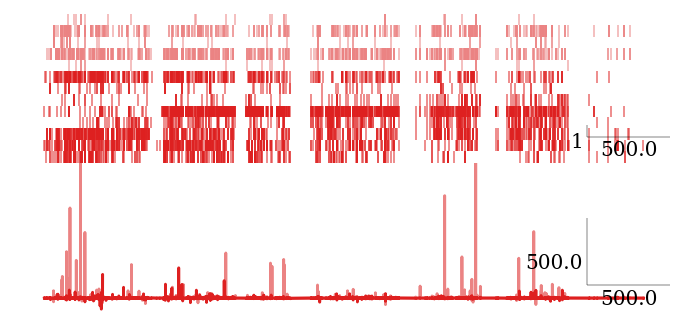

<Figure size 432x288 with 0 Axes>

In [392]:
fig, axs = plt.subplots(2,1,
    figsize=functions.set_size("thesis", fraction=1, subplots=(1.5, 2)),
    edgecolor=None,
    sharex=True,
)
fig.subplots_adjust(hspace=0, wspace=0.1)
axs = axs.ravel()
fig.patch.set_alpha(0)

epoch = nel.EpochArray(
    [
        results["assembly_act_post"].abscissa_vals.min(),
        results["assembly_act_post"].abscissa_vals.min() + 60 * 60,
    ]
)
results.get("react").ripples

group_colors_assemblies = {
    "deep_mec": "#de2020",
    "superficial_mec": "#eb8383",
    "deep_pfc": "#0a4242",  #  "#116f70"
    "superficial_pfc": "#6eb5b5",  # "#568c8c"
}
plt.figure()
npl.rasterplot(
    results["react"].st.iloc[:, is_member[4, :]][results.get("react").ripples][epoch],
    lw=1,
    lh=1,
    ax=axs[0],
    color=group_colors_assemblies["deep_mec"],
    vertstack=True,
    alpha=0.5,
)
npl.rasterplot(
    results["react"].st.iloc[:, is_member[10, :] | is_member[13, :]][
        results.get("react").ripples
    ][epoch],
    lw=1,
    lh=1,
    ax=axs[0],
    color=group_colors_assemblies["superficial_mec"],
    vertstack=True,
    alpha=0.5,
)
# sns.despine(bottom=True, left=True)
axs[1].plot(
    results["assembly_act_post"][epoch].abscissa_vals,
    results["assembly_act_post"][epoch].data[deep_mec_assem_n.astype(int), :].T,
    color=group_colors_assemblies["deep_mec"],
)
axs[1].plot(
    results["assembly_act_post"][epoch].abscissa_vals,
    results["assembly_act_post"][epoch].data[superficial_mec_assem_n.astype(int), :].T,
    color=group_colors_assemblies["superficial_mec"],
    zorder=-1000,
)
axs[1].set_ylim(-100, 1000)

scalebars.add_scalebar(axs[0])
scalebars.add_scalebar(axs[1])

# scalebars.add_scalebar(axs[0], loc="lower right", matchx=True, matchy=False)
# scalebars.add_scalebar(axs[0], loc="lower left", matchx=False, matchy=True, borderpad=-2)
# scalebars.add_scalebar(axs[1], loc="lower right", matchx=True, matchy=False)
# scalebars.add_scalebar(axs[1], loc="lower left", matchx=False, matchy=True, borderpad=-2)

# axs[0].axes.get_yaxis().set_visible(False)
# axs[1].axes.get_yaxis().set_visible(False)
# axs[0].axes.get_xaxis().set_visible(False)
# axs[1].axes.get_xaxis().set_visible(False)

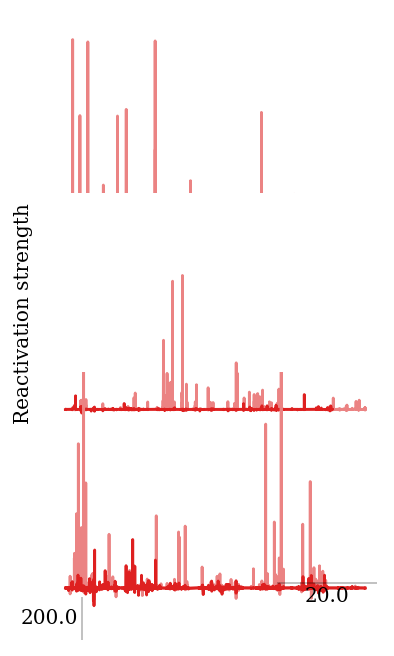

In [329]:
fig, axs = plt.subplots(3,1,
    figsize=functions.set_size("thesis", fraction=0.5, subplots=(3, 1)),
    edgecolor=None,
    sharey=True,
)
fig.subplots_adjust(hspace=-0.25, wspace=0.1)
axs = axs.ravel()
fig.patch.set_alpha(0)

epoch = nel.EpochArray(
    [
        results["assembly_act_pre"].abscissa_vals.min(),
        results["assembly_act_pre"].abscissa_vals.min() + 60 * 60,
    ]
)

axs[0].plot(
    results["assembly_act_pre"][epoch].abscissa_vals / 60,
    results["assembly_act_pre"][epoch].data[deep_mec_assem_n.astype(int), :].T,
    color=group_colors_assemblies["deep_mec"],
)
axs[0].plot(
    results["assembly_act_pre"][epoch].abscissa_vals / 60,
    results["assembly_act_pre"][epoch].data[superficial_mec_assem_n.astype(int), :].T,
    color=group_colors_assemblies["superficial_mec"],
    zorder=-1000,
)

epoch = nel.EpochArray(
    [
        results["assembly_act_task"].abscissa_vals.min(),
        results["assembly_act_task"].abscissa_vals.min() + 60 * 60,
    ]
)
axs[1].plot(
    results["assembly_act_task"][epoch].abscissa_vals / 60,
    results["assembly_act_task"][epoch].data[deep_mec_assem_n.astype(int), :].T,
    color=group_colors_assemblies["deep_mec"],
)
axs[1].plot(
    results["assembly_act_task"].abscissa_vals / 60,
    results["assembly_act_task"].data[superficial_mec_assem_n.astype(int), :].T,
    color=group_colors_assemblies["superficial_mec"],
    zorder=-1000,
)

epoch = nel.EpochArray(
    [
        results["assembly_act_post"].abscissa_vals.min(),
        results["assembly_act_post"].abscissa_vals.min() + 60 * 60,
    ]
)
axs[2].plot(
    results["assembly_act_post"][epoch].abscissa_vals / 60,
    results["assembly_act_post"][epoch].data[deep_mec_assem_n.astype(int), :].T,
    color=group_colors_assemblies["deep_mec"],
)
axs[2].plot(
    results["assembly_act_post"][epoch].abscissa_vals / 60,
    results["assembly_act_post"][epoch].data[superficial_mec_assem_n.astype(int), :].T,
    color=group_colors_assemblies["superficial_mec"],
    zorder=-1000,
)

axs[0].set_ylim(-100, 1000)

scalebars.add_scalebar(axs[2], loc="lower right", matchx=True, matchy=False)
scalebars.add_scalebar(
    axs[2], loc="lower left", matchx=False, matchy=True, borderpad=-2
)

sns.despine(bottom=True, left=True)
axs[0].axes.get_yaxis().set_visible(False)
axs[1].axes.get_yaxis().set_visible(False)
axs[2].axes.get_yaxis().set_visible(False)
axs[0].axes.get_xaxis().set_visible(False)
axs[1].axes.get_xaxis().set_visible(False)
axs[2].axes.get_xaxis().set_visible(False)

fig.text(0.04, 0.5, "Reactivation strength", va="center", rotation="vertical")

plt.savefig(
    os.path.join(fig_save_path, "react_example_cross_region_MEC.svg"),
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)
